In [25]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
transform = transforms.Compose([transforms.Resize((28, 28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [28]:
# pin_memory is related to processing with GPU 
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, pin_memory=True)

In [40]:
# Corrected im_convert function
def im_convert(tensor):
    tensor = tensor.cpu()
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    return image

In [30]:
class LeNet(nn.Module):
   def __init__(self):
       super().__init__()
       # input channel size is 1, number of output channels is 20, 5 is kernel size and 1 is stride
       self.conv1 = nn.Conv2d(1, 20, 5, 1)
       self.conv2 = nn.Conv2d(20, 50, 5, 1)
       self.fc1 = nn.Linear(4*4*50, 500)
       self.dropout1 = nn.Dropout(0.5)
       self.fc2 = nn.Linear(500, 10)
       
   def forward(self, x):
       x = F.relu(self.conv1(x))
       x = F.max_pool2d(x, 2, 2)
       x = F.relu(self.conv2(x))
       x = F.max_pool2d(x, 2, 2)
       x = x.view(-1, 4*4*50)
       x = F.relu(self.fc1(x))
       x = self.dropout1(x)
       x = self.fc2(x)
       return x

In [31]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [33]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

for e in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0

    test_running_loss = 0.0
    test_running_corrects = 0.0

    for inputs, labels in training_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)


    else:
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs = test_inputs.to(device)
                test_labels = test_labels.to(device)

                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_labels)

                _, test_preds = torch.max(test_outputs, 1)
                test_running_loss += test_loss.item()
                test_running_corrects += torch.sum(test_preds == test_labels.data)

        epoch_loss = running_loss / len(training_loader)
        epoch_accuracy = running_corrects.float() / len(training_loader)

        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_accuracy)
        # ==========================//test//======================
        test_epoch_loss = test_running_loss / len(test_loader)
        test_epoch_accuracy = test_running_corrects.float() / len(test_loader)

        test_running_loss_history.append(test_epoch_loss)
        test_running_corrects_history.append(test_epoch_accuracy)

        print(f'epoch {e + 1}')
        print('training loss:{:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_accuracy.item()))
        print('test loss:{:.4f}, test accuracy {:.4f}'.format(test_epoch_loss, test_epoch_accuracy.item()))

epoch 1
training loss:0.5629, accuracy 85.0517
test loss:0.1753, test accuracy 94.8500
epoch 2
training loss:0.1398, accuracy 95.8200
test loss:0.1005, test accuracy 97.1100
epoch 3
training loss:0.0951, accuracy 97.1550
test loss:0.0783, test accuracy 97.6200
epoch 4
training loss:0.0730, accuracy 97.7733
test loss:0.0625, test accuracy 98.0400
epoch 5
training loss:0.0619, accuracy 98.1317
test loss:0.0523, test accuracy 98.4200
epoch 6
training loss:0.0524, accuracy 98.4033
test loss:0.0446, test accuracy 98.5400
epoch 7
training loss:0.0460, accuracy 98.6317
test loss:0.0411, test accuracy 98.6800
epoch 8
training loss:0.0412, accuracy 98.7817
test loss:0.0402, test accuracy 98.7900
epoch 9
training loss:0.0376, accuracy 98.8717
test loss:0.0386, test accuracy 98.6900
epoch 10
training loss:0.0343, accuracy 98.9500
test loss:0.0329, test accuracy 98.8900
epoch 11
training loss:0.0323, accuracy 98.9967
test loss:0.0341, test accuracy 98.8300
epoch 12
training loss:0.0295, accuracy 9

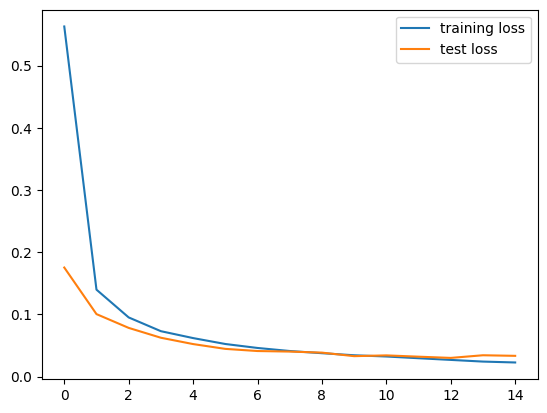

In [34]:
plt.plot(running_loss_history, label='training loss')
plt.plot(test_running_loss_history, label='test loss')
plt.legend()

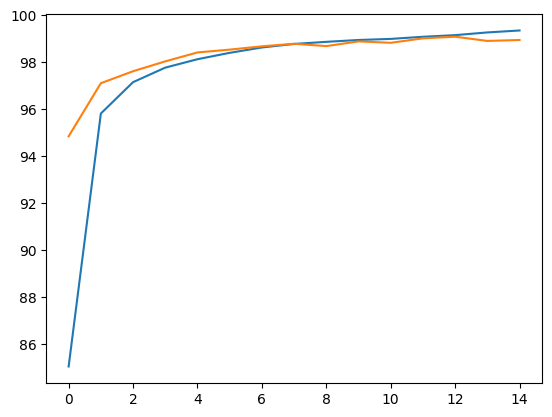

In [35]:
# Assuming running_corrects_history is a list of PyTorch tensors
# Convert and move tensors to CPU and then convert to NumPy arrays
running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in running_corrects_history]
test_running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in test_running_corrects_history]

plt.plot(running_corrects_history_numpy, label='accuracy')
plt.plot(test_running_corrects_history_numpy, label='test accuracy')


In [37]:
# saving the model

model_path = './trained-models/ConvNet-Model'
torch.save(model.state_dict(), model_path)

In [ ]:
# loading the model
# model = LeNet().to(device)
# model_path = './trained-model/first-model'
# model.load_state_dict(torch.load(model_path))

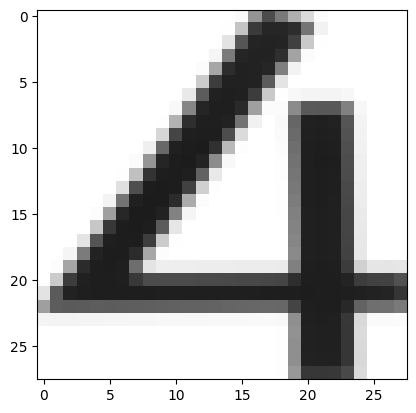

In [41]:
import requests
from PIL import Image
import PIL.ImageOps

url = 'https://m.media-amazon.com/images/I/61SGLu-zNQL._AC_SY355_.jpg'

response = requests.get(url, stream=True)
img = Image.open(response.raw)

img = img.convert('L')
# img = PIL.ImageOps.invert(img)
img = transform(img)
plt.imshow(im_convert(img))

In [43]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)

test_outputs = model(image)
_, pred = torch.max(test_outputs, 1)
print(pred.item())

6


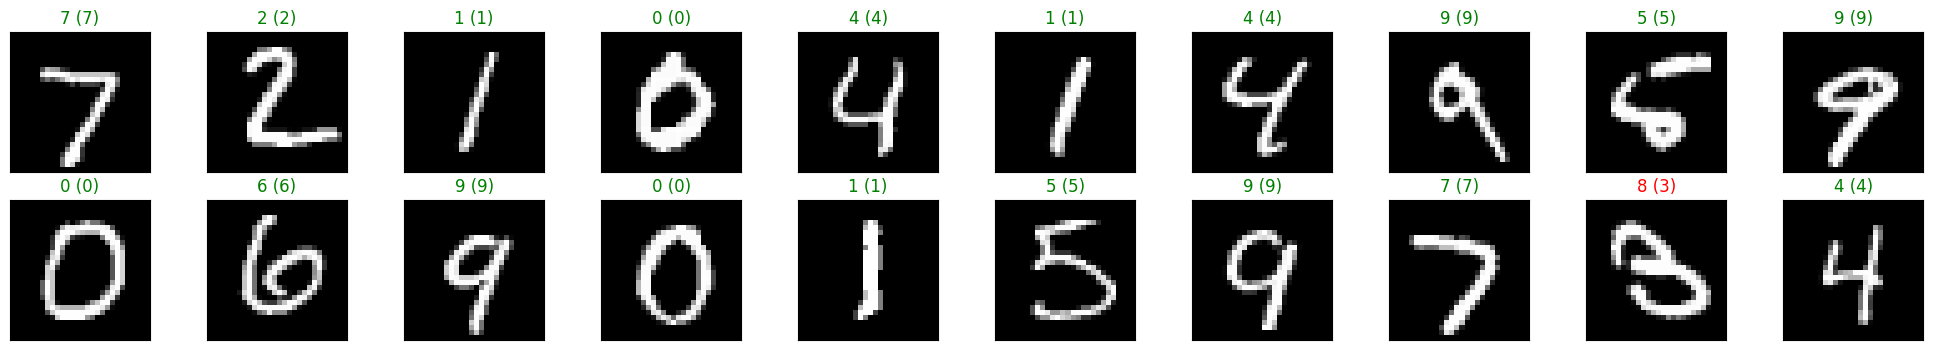

In [45]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

# running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in running_corrects_history]


for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(
        "{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
        color=('green' if preds[idx] == labels[idx] else "red"))